In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
%cd '/content/drive/MyDrive/Colab Notebooks/Optimization-project'

/content/drive/MyDrive/Colab Notebooks/Optimization-project


In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='whitegrid')
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [4]:
# Dataset can be downloaded here : https://www.kaggle.com/shivam2503/diamonds
dset = pd.read_csv('diamonds.csv')
# Delete id :
dset = dset.drop(['id'],axis=1)

#Delete missing values :
dset[['x','y','z']] = dset[['x','y','z']].replace(0,np.NaN)
dset.dropna(inplace=True)
set(dset['clarity'])

{'I1', 'IF', 'SI1', 'SI2', 'VS1', 'VS2', 'VVS1', 'VVS2'}

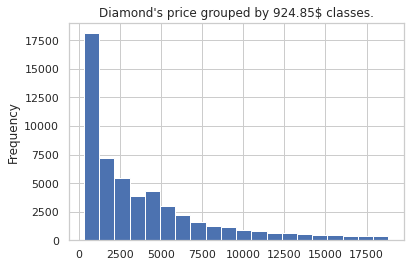

In [5]:
#Plot of the distribution
prices = dset['price']
carat = dset['carat']
bins = 20
class_size = (max(prices) - min(prices))/bins
prices.plot.hist(bins=20)
plt.title("Diamond's price grouped by {:.2f}$ classes.".format(class_size))
plt.savefig('Price distribution.png')
plt.show()

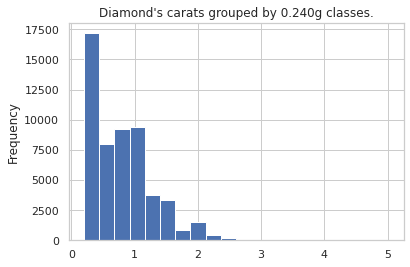

In [6]:
plt.clf()
carat = dset['carat']
bins = 20
class_size = (max(carat) - min(carat))/bins
carat.plot.hist(bins=20)
plt.title("Diamond's carats grouped by {:.3f}g classes.".format(class_size))
plt.savefig('Carats distribution.png')
plt.show()

In [7]:
# Data encoding
label_encoder = preprocessing.LabelEncoder() 

dset['cut'] = label_encoder.fit_transform(dset['cut'])
dset['color'] = label_encoder.fit_transform(dset['color'])
dset['clarity'] = label_encoder.fit_transform(dset['clarity'])
dset.describe()

,carat,cut,color,clarity,depth,table,price,x,y,z
count,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000
mean,0.797698,2.553079,2.594028,3.835441,61.749514,57.456834,3930.993231,5.731627,5.734887,3.540046
std,0.473795,1.027705,1.701272,1.724549,1.432331,2.234064,3987.280446,1.119423,1.140126,0.702530
min,0.200000,0.000000,0.000000,0.000000,43.000000,43.000000,326.000000,3.730000,3.680000,1.070000
25%,0.400000,2.000000,1.000000,2.000000,61.000000,56.000000,949.000000,4.710000,4.720000,2.910000
50%,0.700000,2.000000,3.000000,4.000000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,3.000000,4.000000,5.000000,62.500000,59.000000,5323.250000,6.540000,6.540000,4.040000
max,5.010000,4.000000,6.000000,7.000000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


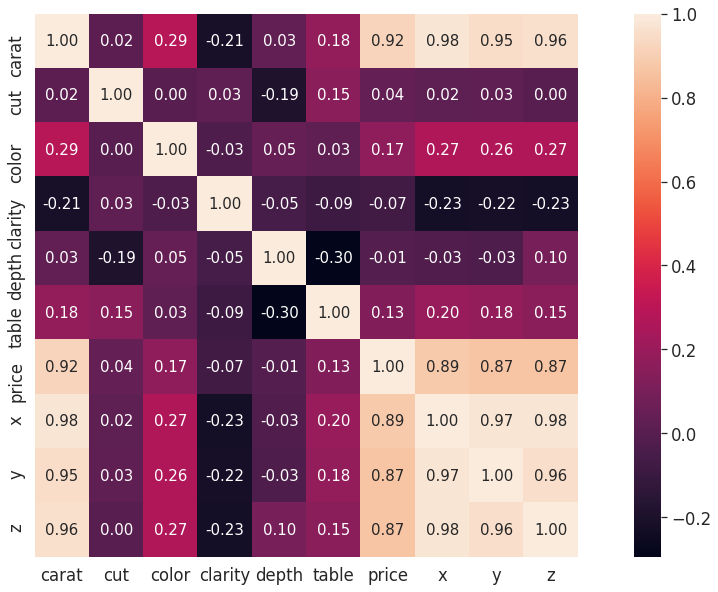

In [8]:
# Calculate and show correlation matrix
plt.figure(figsize=(20,10))
cm = np.corrcoef(dset.values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(dset.corr(),
                cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                annot_kws={'size': 15})#,
                #yticklabels=cols,
                #xticklabels=cols)
#sns.yticks(rotate=90)
plt.savefig('Correlation_matrix.png')
plt.show()

In [11]:
""" 
Reorganizing dataset
  We note that:
  - The clarity and color have little linear correlation with the price (0.17 and -0.07)
  - The main linear correlations are between "carat", "price", "x", "y" and "z".
"""
# Creating train-test split
scaler = StandardScaler()
X = dset.to_numpy()
scaled_dset = pd.DataFrame(scaler.fit_transform(X))
scaled_dset.columns = dset.columns
scaled_dset.index = dset.index
scaled_dset.head()

X = scaled_dset.drop(['price'], axis = 1).to_numpy()
Y = scaled_dset['price'].to_numpy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = int(len(dset)*0.2), random_state = 42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = int(len(X_train)*0.2))

In [12]:
#Résolution analytique:
def loss(X, W, Y, alpha = 0):
  n = X.shape[0]
  R = X.dot(W)-Y
  return 0.5/n*np.linalg.norm(R)**2 + 0.5*alpha*np.linalg.norm(W)

def solve(X, Y, alpha = 0):
  n = X.shape[0]
  return np.linalg.inv(X.T@X + n*alpha*np.eye(X.shape[1]))@X.T@Y

def compute_th_loss(X, Y, alpha_reg = 0):
  W = solve(X, Y, alpha_reg)
  return loss(X, W, Y, alpha_reg)
th_loss = compute_th_loss(X_train, Y_train, 0)
print(th_loss)

0.05781424641517619


In [13]:
#Gradient descent:
def batch_gradient_descent(X, Y, W0, X_val=None, Y_val=None, patience = 10, lr=0.001, nb_iter = 100, batch_size = 512, momentum = 0, nesterov = False, alpha_reg = 0):
  best_val_loss = np.inf
  early_stop_counter = 0
  W_old = W0
  W_current = W0
  y_old = W0
  th_loss = compute_th_loss(X_train, Y_train, alpha_reg)
  init_loss = loss(X, W0, Y, alpha_reg)
  losses = [init_loss]
  if X_val is not None:
    val_losses = [loss(X_val, W0, Y_val, alpha_reg)]
  descent_losses = [init_loss-th_loss]
  update_old = 0.
  for i in range(nb_iter):
    epoch_loss = 0.
    
    # Manually enumerate batches
    indexes = np.arange(len(X_train))
    np.random.shuffle(indexes)
    batch_id = 0
    while (batch_id+1)*batch_size < len(X_train):
      X_batch = X_train[indexes[batch_id*batch_size: (batch_id+1)*batch_size]]
      Y_batch = Y_train[indexes[batch_id*batch_size: (batch_id+1)*batch_size]]
      
      if nesterov == False:
        g_W = 1/batch_size*X_batch.T@(X_batch@W_current-Y_batch) + alpha_reg*W_current
        W_new = W_current - momentum*(W_current-W_old) - lr*g_W
        W_old = W_current
        W_current = W_new
      
      if nesterov == True:
        g_nesterov = 1/batch_size*X_batch.T@(X_batch@(W_current-momentum*update_old)-Y_batch) + alpha_reg*W_current-momentum*update_old
        update_new = momentum*update_old + lr*g_nesterov
        W_new = W_current - update_new
        W_old = W_current
        W_current = W_new
        update_old = update_new
      
      batch_id +=1
      batch_loss = loss(X_batch, W_current, Y_batch, alpha_reg)
      epoch_loss +=batch_loss

    epoch_loss/=(batch_id+1) # --> /= len(loader)
    descent_loss = abs(epoch_loss - th_loss)
    losses.append(epoch_loss)
    descent_losses.append(descent_loss)

    if X_val is not None:
      val_loss = loss(X_val, W_current, Y_val, alpha_reg)
      val_losses.append(val_loss)
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_W_val = W_new
        early_stop_counter = 0
      elif val_loss>=best_val_loss:
        early_stop_counter +=1
        if early_stop_counter>=patience:
          print('Early stopping at epoch {}'.format(i+1))
          break
  if X_val is not None:
    return losses, best_W_val, descent_losses, best_val_loss
  return losses, W_current, descent_losses

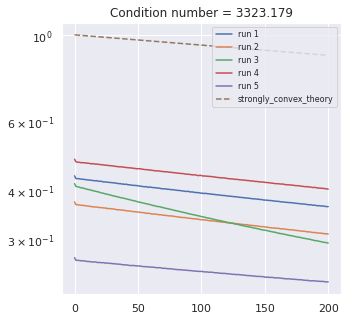

In [64]:
#Param definition
nb_iter = 200 #Epochs
nb_runs = 5 # Number of experiments
stochastic_runs = True

# Tables to save results
cur_losses = []
descent_losses = []
Ws = []

# Calculus of the strongly convex condition
(eig_vals,_) = np.linalg.eig(X_train.transpose().dot(X_train))
L = max(eig_vals)
mu = min(eig_vals)
its = np.arange(0,nb_iter+1)
theory_strongly_cvx = L/2 * ((L-mu)/(L+mu))**its#/70989
theory_strongly_cvx /=theory_strongly_cvx[0]

W0 = np.random.rand(X_train.shape[1])
W0 /=np.linalg.norm(W0)

params = np.zeros((nb_runs,6))
params[:,0] = [1/L]*nb_runs#[3/L, 2/L, 1/L, 1/(2*L),1/(3*L)]
#params[:,0] = [1e-2,1e-3, 1e-4, 1e-5, 1e-6]
params[:,1] = [0]*nb_runs # Momentum
params[:,2] = [True]*nb_runs # Nesterov
params[:,3] = [512]*nb_runs#[1, 8, 16, 128, 512]# Batch size
params[:,4] = [0]*nb_runs # alpha_reg
#labels = ['lr = {}'.format(params[i, 0]) for i in range(nb_runs)]
#labels = ['lr = 3/L', 'lr = 2/L', 'lr = 1/L', 'lr = 1/(2L)', 'lr = 1/(3L)']
#labels = ['batch_size = {}'.format(params[i, 3]) for i in range(nb_runs)]
#labels = ['Nesterov momentum = {}'.format(params[i,1]) for i in range(nb_runs)]
#labels = ['Momentum = {}'.format(params[0,1]), 'Momentum = {}'.format(params[1,1]), 'Momentum = {}'.format(params[2,1]), 'Nesterov momentum = {}'.format(params[3,1]), 'Nesterov momentum = {}'.format(params[4,1])]
#labels = ['alpha_reg = {}'.format(params[i, 4]) for i in range(nb_runs)]
labels = ['run {}'.format(i+1) for i in range(nb_runs)]

plt.figure(figsize=(5,5))
for i, param in enumerate(params): 
  if stochastic_runs: # Changing initialization every run
    W0 = np.random.rand(X_train.shape[1])
    W0 /=np.linalg.norm(W0)

  cur_loss, W, descent_loss = batch_gradient_descent(X_train, Y_train, W0 = W0, nb_iter = nb_iter, lr = param[0], momentum = param[1], nesterov = param[2], batch_size = int(param[3]), alpha_reg = param[4])
                                                                                                                                                                                                    
  cur_losses.append(cur_loss)
  Ws.append(W)
  descent_losses.append(descent_loss)
  plt.yscale('log')
  plt.plot(its, cur_loss, label = labels[i])

plt.plot(theory_strongly_cvx,'--', label = 'strongly_convex_theory')
#plt.plot(its, [th_loss for i in its], '--', label='minimal_theoretical_loss')
plt.legend(fontsize = 8.)
plt.savefig('SGD-convergence-results.png')
#plt.savefig('SGD-loss-results.png')
#plt.savefig('learning-rate-tuning-loss.png')
#plt.savefig('learning-rate-tuning-loss-1.png')
#plt.savefig('batch-size-tuning-loss.png')
#plt.savefig('momentum-tuning-loss.png')
#plt.savefig('Nesterov-momentum-tuning-loss.png')
plt.title('Condition number = {:.3f}'.format(L/mu))
plt.show()

In [19]:
print(th_loss,cur_losses[0][-1])

0.05781424641517619 0.05712805428826471


In [20]:
#Cross validation and test result:
nb_max_iter = 200 #Epochs
stochastic_runs = False

# Tables to save results
cur_losses = []
descent_losses = []
Ws = []

W0 = np.random.rand(X_train.shape[1])
W0 /=np.linalg.norm(W0)

lrs = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6] #[1e-3, 1e-4, 1e-5, 1e-6]
nesterovs = [False, True]
batch_sizes = [64, 128, 512]
momentums = [0, 0.3, 0.5, 0.7, 0.9]
alpha_regs = np.linspace(0, 0.1, 5)

R_matrix = np.zeros(shape = (len(batch_sizes), len(nesterovs), len(lrs), len(momentums), len(alpha_regs)))
W_matrix = np.zeros(shape = (len(batch_sizes), len(nesterovs), len(lrs), len(momentums), len(alpha_regs), W0.shape[0]))

for i, batch_size in enumerate(batch_sizes):
  for j, nesterov in enumerate(nesterovs):
    for k, lr in enumerate(lrs):
      for l, momentum in enumerate(momentums):
        for m, alpha_reg in enumerate(alpha_regs):
          print('batch_size = {}, nesterov = {}, lr = {}, momentum = {}, alpha_reg = {} '.format(batch_size, nesterov, lr, momentum, alpha_reg))
          cur_loss, W, descent_loss, val_loss = batch_gradient_descent(X_train,
                                                                         Y_train,
                                                                         W0 = W0,
                                                                         X_val = X_val,
                                                                         Y_val = Y_val,
                                                                         nb_iter = nb_max_iter,
                                                                         lr = lr,
                                                                         momentum = momentum,
                                                                         nesterov = nesterov,
                                                                         batch_size = batch_size,
                                                                         alpha_reg = alpha_reg)                                                                                                                                                                                         
          #cur_losses.append(cur_loss)
          W_matrix[i, j, k, l, m] = W
          R_matrix[i, j, k, l, m] = val_loss

batch_size = 64, nesterov = False, lr = 0.01, momentum = 0, alpha_reg = 0.0 
Early stopping at epoch 34
batch_size = 64, nesterov = False, lr = 0.01, momentum = 0, alpha_reg = 0.025 
Early stopping at epoch 35
batch_size = 64, nesterov = False, lr = 0.01, momentum = 0, alpha_reg = 0.05 
Early stopping at epoch 25
batch_size = 64, nesterov = False, lr = 0.01, momentum = 0, alpha_reg = 0.07500000000000001 
Early stopping at epoch 22
batch_size = 64, nesterov = False, lr = 0.01, momentum = 0, alpha_reg = 0.1 
Early stopping at epoch 21
batch_size = 64, nesterov = False, lr = 0.01, momentum = 0.3, alpha_reg = 0.0 
Early stopping at epoch 41
batch_size = 64, nesterov = False, lr = 0.01, momentum = 0.3, alpha_reg = 0.025 
Early stopping at epoch 44
batch_size = 64, nesterov = False, lr = 0.01, momentum = 0.3, alpha_reg = 0.05 
Early stopping at epoch 44
batch_size = 64, nesterov = False, lr = 0.01, momentum = 0.3, alpha_reg = 0.07500000000000001 
Early stopping at epoch 26
batch_size = 64, n

In [21]:
import torch
torch.save(R_matrix, 'R_matrix.pt')
torch.save(W_matrix, 'W_matrix.pt')

In [22]:
for i in range(R_matrix.shape[0]):
  for j in range(R_matrix.shape[1]):
    for k in range(R_matrix.shape[2]):
      for l in range(R_matrix.shape[3]):
        for m in range(R_matrix.shape[4]):
          if np.isnan(R_matrix[i,j,k,l,m]):
            R_matrix[i,j,k,l,m] = np.inf
print(np.amin(R_matrix[0]))
np.where(R_matrix == np.amin(R_matrix[0]))

0.05785048275701387


(array([0]), array([0]), array([0]), array([3]), array([0]))

In [23]:
""" Optimal parameters
val_loss = 0.06105204439235931
lr = 1e-3
Nesterov = True
Batch size = 512
Momentum = 0.9
Learning rate decay = 0
alpha_reg = 0.05

val_loss = 0.06063059033305039
lr = 1e-2
Nesterov = True
Batch size = 512
Momentum = 0.7
lr_decay = 0
alpha_reg = 0.07

"""

' Optimal parameters\nval_loss = 0.06105204439235931\nlr = 1e-3\nNesterov = True\nBatch size = 512\nMomentum = 0.9\nLearning rate decay = 0\nalpha_reg = 0.05\n\nval_loss = 0.06063059033305039\nlr = 1e-2\nNesterov = True\nBatch size = 512\nMomentum = 0.7\nlr_decay = 0\nalpha_reg = 0.07\n\n'

(array([0]), array([0]), array([0]), array([0]), array([3]))


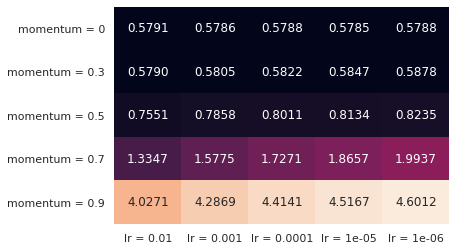

In [38]:
R_projection = np.swapaxes(R_matrix, -1, -3)
R_projection = np.swapaxes(R_projection, -1, -2)
print(np.where(R_projection == np.amin(R_projection)))
sns.set(font_scale=1)
sns.heatmap(R_projection[0,0,0]*10,
            annot = True,
            cbar = False,
            xticklabels=['lr = {}'.format(lrs[i]) for i in range(len(lrs))],
            yticklabels = ['momentum = {}'.format(momentums[i]) for i in range(len(momentums))],
            fmt = '.4f')
plt.xticks(rotation = 0)
plt.savefig('R_projection_lr_momentum.png')
plt.show()

In [56]:
#R_matrix = torch.load('R_matrix.pt')
#W_matrix = torch.load('W_matrix.pt')
print(np.where(R_matrix == np.amin(R_matrix)))
W_final = W_matrix[0, 0, 0, 3, 0]
print(W_final.shape)
print(np.amin(R_matrix))
print(R_matrix[0,0,0,3,0])
print(loss(X_val, W_final, Y_val, alpha = alpha_regs[0]))
print(loss(X_test, W_final, Y_test, alpha = alpha_regs[0]))

(array([0]), array([0]), array([0]), array([3]), array([0]))
(9,)
0.05785048275701387
0.05785048275701387
0.05785048275701387
0.05478440350180266


In [58]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
regr = LinearRegression()
model = regr.fit(X_train, Y_train)
W_scikit = regr.coef_
y_pred_SGD = X_test@W_final
y_pred_scikit = model.predict(X_test)

print('scikit loss = {}'.format(loss(X_test, W_scikit, Y_test, alpha = 0)))
print('SGD loss = {}'.format(loss(X_test, W_final, Y_test, alpha = 0)))
print("scikit-RMSE: {}".format(np.sqrt(mean_squared_error((Y_test),(y_pred_scikit)))))
print("SGD-RMSE: {}".format(np.sqrt(mean_squared_error((Y_test),(y_pred_SGD)))))
print("scikit-R2  : {}".format(np.sqrt(r2_score((Y_test),(y_pred_scikit)))))
print("SGD-R2  : {}".format(np.sqrt(r2_score((Y_test),(y_pred_SGD)))))

scikit loss = 0.07283878760990202
SGD loss = 0.05478440350180266
scikit-RMSE: 0.3816739666172198
SGD-RMSE: 0.33101179284672816
scikit-R2  : 0.9249546634690845
SGD-R2  : 0.944111175618063


In [ ]:
# https://www.codingame.com/playgrounds/9487/deep-learning-from-scratch---theory-and-implementation/gradient-descent-and-backpropagation